In [1]:
import cv2
import os
import numpy as np
from random import shuffle
from tqdm import tqdm
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import pathlib
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


In [2]:
data_dir = 'archive'
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4000


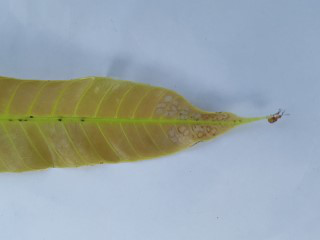

In [4]:
Anthracnose = list(data_dir.glob('Anthracnose/*'))
PIL.Image.open(str(Anthracnose[0]))

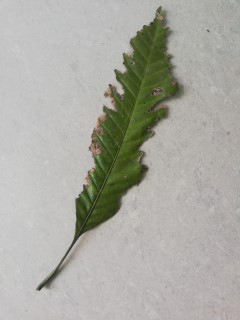

In [5]:
bc = list(data_dir.glob('Bacterial Canker/*'))
PIL.Image.open(str(bc[0]))

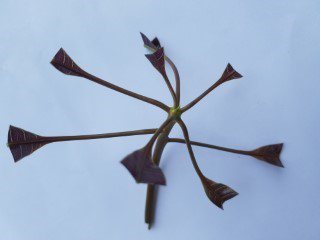

In [6]:
cw = list(data_dir.glob('Cutting Weevil/*'))
PIL.Image.open(str(cw[0]))

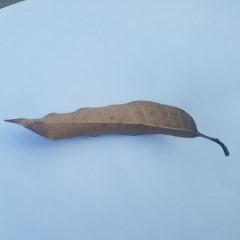

In [7]:
db = list(data_dir.glob('Die Back/*'))
PIL.Image.open(str(db[0]))

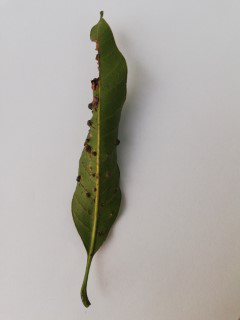

In [8]:
gm = list(data_dir.glob('Gall Midge/*'))
PIL.Image.open(str(gm[0]))

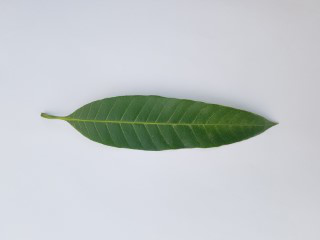

In [9]:

h = list(data_dir.glob('Healthy/*'))
PIL.Image.open(str(h[0]))

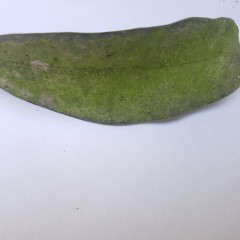

In [10]:
pm = list(data_dir.glob('Powdery Mildew/*'))
PIL.Image.open(str(pm[0]))


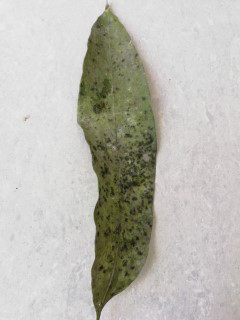

In [11]:

sm = list(data_dir.glob('Sooty Mould/*'))
PIL.Image.open(str(sm[0]))

In [12]:
batch_size = 64
img_height = 240
img_width = 320

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 3600 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 400 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
     

(64, 240, 320, 3)
(64,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06666667 1.0


# CNN Model 1: A Basic Keras Model

In [20]:
num_classes = len(class_names)

cnn_model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
cnn_model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 320, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 160, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 160, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 80, 64)        1

In [23]:
from tensorflow.keras.utils import plot_model

In [24]:
import pydot
import pydotplus
import graphviz

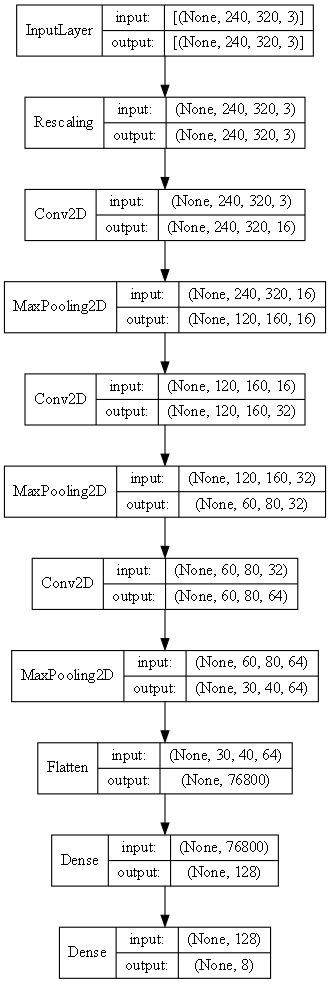

In [25]:
plot_model(cnn_model_1,
           to_file='model1.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           dpi=80)

In [26]:
epochs=10
history_cnn_model_1 = cnn_model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
57/57 [==============================] - 219s 4s/step - loss: 1.6702 - accuracy: 0.3683 - val_loss: 0.9847 - val_accuracy: 0.6750
Epoch 2/10
57/57 [==============================] - 210s 4s/step - loss: 0.7172 - accuracy: 0.7469 - val_loss: 0.7072 - val_accuracy: 0.7200
Epoch 3/10
57/57 [==============================] - 210s 4s/step - loss: 0.3745 - accuracy: 0.8653 - val_loss: 0.3855 - val_accuracy: 0.8750
Epoch 4/10
57/57 [==============================] - 210s 4s/step - loss: 0.1732 - accuracy: 0.9456 - val_loss: 0.2406 - val_accuracy: 0.9325
Epoch 5/10
57/57 [==============================] - 212s 4s/step - loss: 0.1144 - accuracy: 0.9661 - val_loss: 0.2148 - val_accuracy: 0.9375
Epoch 6/10
57/57 [==============================] - 210s 4s/step - loss: 0.0873 - accuracy: 0.9697 - val_loss: 0.2608 - val_accuracy: 0.9200
Epoch 7/10
57/57 [==============================] - 207s 4s/step - loss: 0.0452 - accuracy: 0.9883 - val_loss: 0.2141 - val_accuracy: 0.9325
Epoch 8/10
57

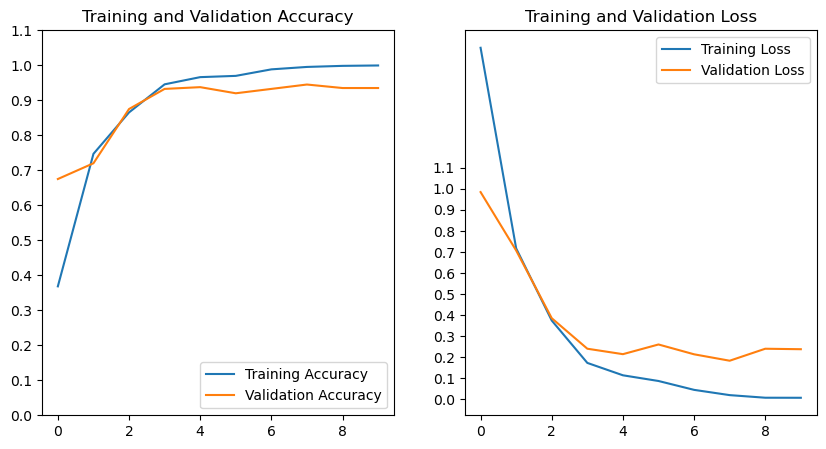

In [90]:
#Plotting Accuracy vs Validation Graphs
acc1 = history_cnn_model_1.history['accuracy']
val_acc1 = history_cnn_model_1.history['val_accuracy']

loss1 = history_cnn_model_1.history['loss']
val_loss1 = history_cnn_model_1.history['val_loss']

y_ticks = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1])
epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Training Accuracy')
plt.plot(epochs_range, val_acc1, label='Validation Accuracy')
plt.yticks(y_ticks)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
plt.yticks(y_ticks)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [28]:
# Importing needed libraries
import matplotlib.pyplot as plt
import numpy as np
import h5py


from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model
     

# CNN Model 2: Experimenting with Convolutional Pooling Pairs

In [29]:
cnn_model_2 = Sequential()

# Adding first pair {8C5-P2}
cnn_model_2.add(Conv2D(8, kernel_size=5, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
cnn_model_2.add(MaxPool2D())

# Adding second pair {16C5-P2}
cnn_model_2.add(Conv2D(16, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding third pair {32C5-P2}
cnn_model_2.add(Conv2D(32, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding fourth pair {64C5-P2}
cnn_model_2.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding fully connected layers
cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(128, activation='relu'))
cnn_model_2.add(Dense(8, activation='softmax'))

In [30]:
cnn_model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

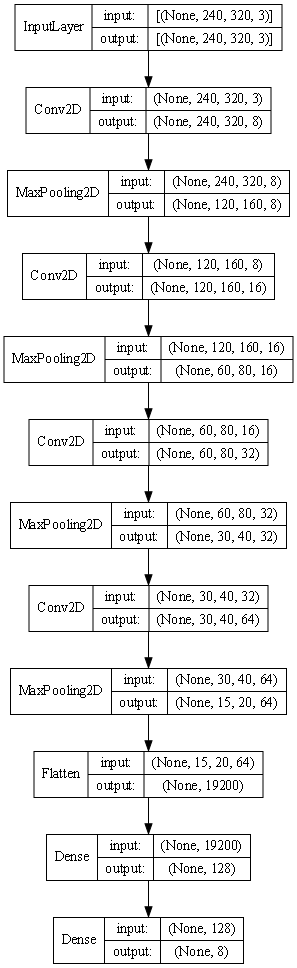

In [31]:
plot_model(cnn_model_2,
           to_file='model2.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           dpi=72)

In [32]:
epochs = 10

# Defining schedule to update learning rate
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs), verbose=1)

In [33]:
epochs=10
history_cnn_model_2 = cnn_model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


C:\Users\SkullReaper\AppData\Roaming\Python\Python310\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 271s 5s/step - loss: 14.9566 - accuracy: 0.3256 - val_loss: 1.1167 - val_accuracy: 0.6300
Epoch 2/10
57/57 [==============================] - 346s 6s/step - loss: 0.9472 - accuracy: 0.6558 - val_loss: 0.9885 - val_accuracy: 0.6500
Epoch 3/10
57/57 [==============================] - 288s 5s/step - loss: 0.6268 - accuracy: 0.7753 - val_loss: 0.6427 - val_accuracy: 0.7725
Epoch 4/10
57/57 [==============================] - 288s 5s/step - loss: 0.3496 - accuracy: 0.8800 - val_loss: 0.4435 - val_accuracy: 0.8600
Epoch 5/10
57/57 [==============================] - 277s 5s/step - loss: 0.1997 - accuracy: 0.9339 - val_loss: 0.4166 - val_accuracy: 0.8575
Epoch 6/10
57/57 [==============================] - 280s 5s/step - loss: 0.1640 - accuracy: 0.9450 - val_loss: 0.4619 - val_accuracy: 0.8350
Epoch 7/10
57/57 [==============================] - 287s 5s/step - loss: 0.0996 - accuracy: 0.9689 - val_loss: 0.4368 - val_accuracy: 0.8825
Epoch 8/10
57/57 [=====

range(0, 10)


Text(0.5, 1.0, 'Training and Validation Loss')

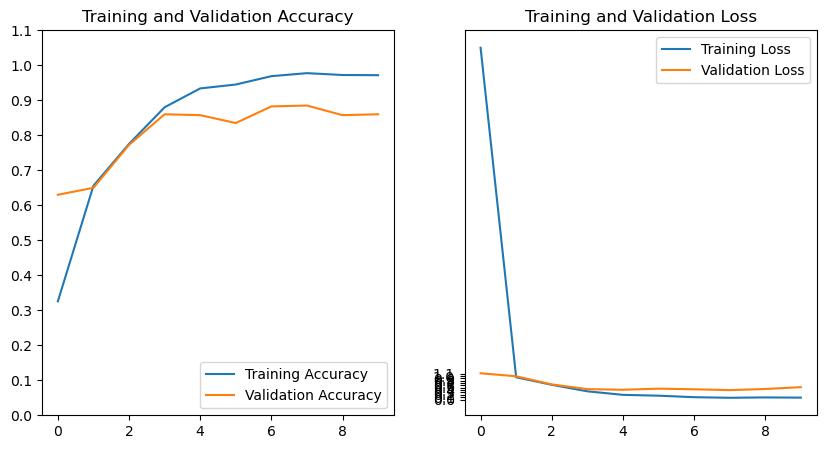

In [63]:
acc2 = history_cnn_model_2.history['accuracy']
val_acc2 = history_cnn_model_2.history['val_accuracy']

loss2 = history_cnn_model_2.history['loss']
val_loss2 = history_cnn_model_2.history['val_loss']

epochs_range = range(len(acc))
print(epochs_range)

y_ticks = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.yticks(y_ticks)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

epochs_range = range(epochs)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.yticks(y_ticks)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [35]:
import gradio as gr

In [56]:
import glob
from sklearn.model_selection import train_test_split
import os

data = []
labels = []

classes = {}
classes_dir = enumerate(os.listdir(data_dir))
for i, j in classes_dir:
    classes[j] = i
print(classes)


for i in class_names:
  pt = str(data_dir / i / '*.jpg')
  #print(pt)
  image_dir = glob.glob(pt)
  for j in image_dir:
    image=tf.keras.preprocessing.image.load_img(j, color_mode='rgb', 
    target_size= (240,320))
    image=np.array(image)
    data.append(image)
    labels.append(classes[i])
  #print(labels)
  

data = np.array(data)
labels = np.array(labels)
#print(data.shape)
#print(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,random_state=42)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}
(3200, 240, 320, 3) (800, 240, 320, 3) (3200,) (800,)


In [59]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [60]:
np.unique(y_train)
nsamples, nx, ny, nz = X_train.shape
X_train_modified = X_train.reshape((nsamples,nx*ny*nz))
nsamples, nx, ny, nz = X_test.shape
X_test_modified = X_test.reshape((nsamples,nx*ny*nz))

In [64]:
## Random Forest Classification
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_modified,y_train)
random_forest_model_prdiction = random_forest_model.predict(X_test_modified)
rf_acc = accuracy_score(random_forest_model_prdiction,y_test)
print("Report of Random Forest Classification - ")
print(classification_report(random_forest_model_prdiction,y_test))


Report of Random Forest Classification - 
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       113
           1       0.92      0.85      0.88        93
           2       0.98      0.96      0.97       114
           3       0.95      0.95      0.95       101
           4       0.80      0.81      0.80       103
           5       0.91      0.85      0.88        97
           6       0.78      0.95      0.86        75
           7       0.81      0.72      0.76       104

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



In [92]:
## KNN classification
knn_classifier_model = KNeighborsClassifier(n_neighbors=10)
knn_classifier_model.fit(X_train_modified,y_train)
knn_classifier_prediction = knn_classifier_model.predict(X_test_modified)
knn_acc = accuracy_score(knn_classifier_prediction,y_test)
print("Report of KNN Classification - ")
print(classification_report(knn_classifier_prediction,y_test))

Report of KNN Classification - 
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       103
           1       0.90      0.51      0.65       152
           2       0.53      1.00      0.69        59
           3       0.92      0.57      0.70       164
           4       0.47      0.64      0.54        76
           5       0.62      0.67      0.64        84
           6       0.52      0.62      0.56        76
           7       0.58      0.63      0.60        86

    accuracy                           0.63       800
   macro avg       0.64      0.66      0.63       800
weighted avg       0.69      0.63      0.64       800



In [66]:
## Decision Tree Classification
decision_tree_classifier_model = DecisionTreeClassifier()
decision_tree_classifier_model.fit(X_train_modified,y_train)
decision_tree_prediction = decision_tree_classifier_model.predict(X_test_modified)
dt_acc = accuracy_score(decision_tree_prediction,y_test)
print("Report of Decision Tree Classification - ")
print(classification_report(decision_tree_prediction,y_test))
acc = decision_tree_classifier_model.score(X_test_modified,y_test)

Report of Decision Tree Classification - 
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       106
           1       0.65      0.64      0.64        88
           2       0.96      0.94      0.95       114
           3       0.85      0.77      0.81       112
           4       0.60      0.52      0.55       120
           5       0.67      0.57      0.62       105
           6       0.53      0.59      0.56        81
           7       0.45      0.57      0.50        74

    accuracy                           0.67       800
   macro avg       0.66      0.66      0.66       800
weighted avg       0.68      0.67      0.67       800



In [97]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_modified, y_train)
gnb_prediction = gnb.predict(X_test_modified)
gnb_acc = accuracy_score(gnb_prediction,y_test)
print("Report of Gaussian Naive Bayes Classification - ")
print(classification_report(gnb_prediction,y_test))


Report of Gaussian Naive Bayes Classification - 
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       118
           1       0.78      0.71      0.74        94
           2       0.84      0.70      0.76       135
           3       0.46      0.73      0.56        63
           4       0.27      0.39      0.32        72
           5       0.63      0.49      0.55       117
           6       0.52      0.47      0.49       100
           7       0.41      0.38      0.39       101

    accuracy                           0.56       800
   macro avg       0.56      0.56      0.55       800
weighted avg       0.59      0.56      0.57       800



# Comparing Different Models for Image Classification

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


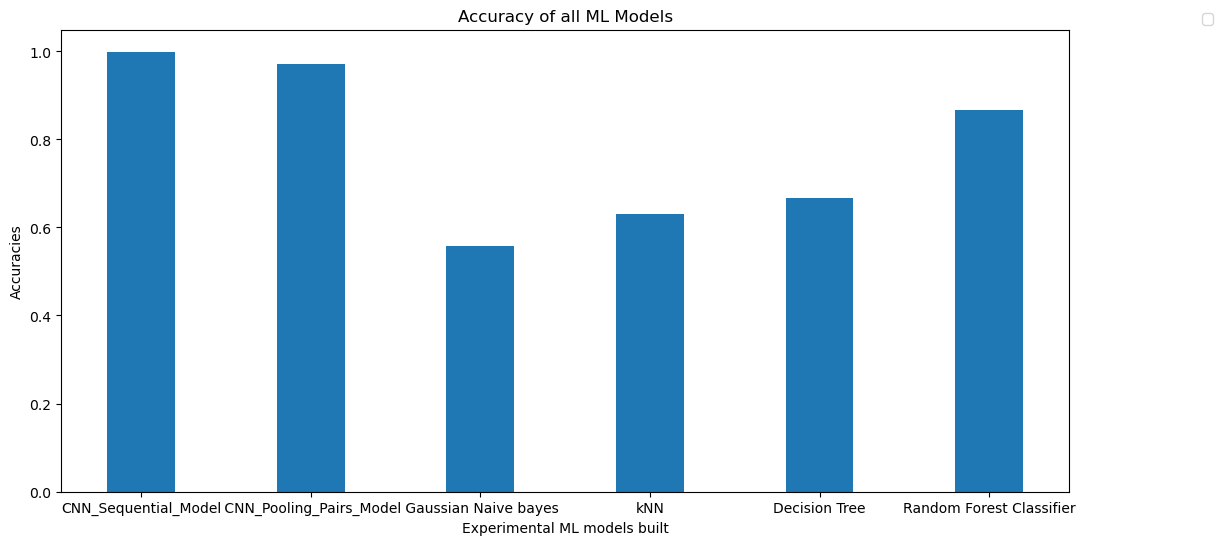

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

models = ['CNN_Sequential_Model',' CNN_Pooling_Pairs_Model', ' Gaussian Naive bayes','kNN', 'Decision Tree', 'Random Forest Classifier']
val_accuracies = [acc1[len(acc1)-1], acc2[len(acc2)-1], gnb_acc, knn_acc, dt_acc, rf_acc]
X_axis = np.arange(len(models))
fig = plt.figure(figsize = (13, 6))
 
# creating the bar plot
plt.bar(X_axis, val_accuracies, width = 0.4)
plt.xticks(X_axis, models)
plt.xlabel("Experimental ML models built")
plt.ylabel("Accuracies")
plt.title("Accuracy of all ML Models")
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()